# DEFINE PROBLEM

- Patients suffering stroke increased more year by year.
- Government need to find out which category of citizen that has stroke status
- Government also need to know what is that might be the cause to it

# DEFINE GOALS

- To find out which category of citizen that has stroke status
- To find out which category of patients that is susceptible to stroke

### IMPORT COMMON PACKAGE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import dython
from dython.nominal import associations, cramers_v, correlation_ratio, theils_u
import dateparser
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_columns = 999

### IMPORT FILE

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df_eda = df.copy()

##### COLUMNS DESCRIPTION
`id` - unique identifier\
`gender` - Patient's Gender\
`age` - Patient's Age\
`hypertension` - 0 if the patient doesn't have hypertension, 1 if the patient has hypertension\
`heart_disease` - 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease\
`ever_married` - Patient's status of marriage \
`work_type` - Patient's type of work\
`Residence_type` -Patient's residence area type\
`avg_glucose_level` - Patient's average glucose level in blood \
`bmi` - Patient's body mass index \
`smoking_status` - Patient's smoking status \
`stroke` - 1 if the patient had a stroke or 0 if not

Source : https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

### DATA TYPE OVERALL CHECK

In [3]:
df_eda.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,nan,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [4]:
df_eda.groupby(['avg_glucose_level','bmi']).mean()

,,id,age,hypertension,heart_disease,stroke
avg_glucose_level,bmi,,,,,
55.12,21.80,60562.00,21.00,0.00,0.00,0.00
55.22,27.00,37404.00,42.00,0.00,0.00,0.00
55.23,28.90,43028.00,66.00,0.00,0.00,0.00
55.25,20.40,61300.00,20.00,0.00,0.00,0.00
55.26,33.20,72547.00,61.00,0.00,0.00,0.00
...,...,...,...,...,...,...
266.59,25.50,27626.00,60.00,0.00,0.00,0.00
267.60,30.50,10995.00,76.00,1.00,0.00,0.00
267.61,27.90,26267.00,76.00,0.00,0.00,0.00


In [5]:
print(df_eda.shape)

(5110, 12)


### COLUMN SUMMARY

In [6]:
strokedesc = []

for i in df_eda.columns:
    strokedesc.append([
        i,
        df_eda[i].dtypes,
        df_eda[i].isna().sum(),
        (((df_eda[i].isna().sum()) / len(df_eda)) * 100).round(2),
        df_eda[i].nunique(),
        df_eda[i].drop_duplicates().sample(2).values
    ])

In [7]:
pd.DataFrame(data = strokedesc,
             columns = [
                 'Features', 
                 'DataType', 
                 'Null', 
                 'NullPercentage', 
                 'Unique', 
                 'Unique Sample'
             ])

,Features,DataType,Null,NullPercentage,Unique,Unique Sample
0,id,int64,0,0.00,5110,"[54579, 43496]"
1,gender,object,0,0.00,3,"[Male, Female]"
2,age,float64,0,0.00,104,"[0.64, 27.0]"
3,hypertension,int64,0,0.00,2,"[1, 0]"
4,heart_disease,int64,0,0.00,2,"[0, 1]"
5,ever_married,object,0,0.00,2,"[Yes, No]"
6,work_type,object,0,0.00,5,"[Private, Never_worked]"
7,Residence_type,object,0,0.00,2,"[Urban, Rural]"
8,avg_glucose_level,float64,0,0.00,3979,"[85.29, 89.99]"
9,bmi,float64,201,3.93,418,"[41.3, 33.3]"


In [8]:
## df.head(), df.shape, df.info() is utilized to capture dataset genereal information

## DATA PREPARATION BEFORE OUTLIERS & MISSING VALUE CHECKING

- Remove unecessary columns => id

In [9]:
df_eda.drop(columns = ['id'], inplace = True)

# DESCRIPTIVE ANALYSIS, HANDLING OUTLIERS, AND HANDLING MISSING VALUE

### DESCRIPTIVE ANALYSIS

In [10]:
round(df_eda.describe(),2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.00,5110.00,4909.00,5110.00
mean,43.23,0.10,0.05,106.15,28.89,0.05
std,22.61,0.30,0.23,45.28,7.85,0.22
min,0.08,0.00,0.00,55.12,10.30,0.00
25%,25.00,0.00,0.00,77.24,23.50,0.00
50%,45.00,0.00,0.00,91.88,28.10,0.00
75%,61.00,0.00,0.00,114.09,33.10,0.00
max,82.00,1.00,1.00,271.74,97.60,1.00


### MISSING VALUE CHECK & HANDLING

In [11]:
df_eda.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [12]:
df_eda['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [13]:
#There's unknown status in smoking_status. Since it has big data, we replace them with most frequent data

In [14]:
df_eda['smoking_status'] = df_eda['smoking_status'].replace('Unknown', 'never smoked')

In [15]:
df_eda['smoking_status'].value_counts()

never smoked       3436
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [16]:
df_clean = df_eda.copy()

In [17]:
#fill missing value with mean
df_clean['bmi'] = df_clean['bmi'].fillna(df_clean['bmi'].mean())

In [18]:
df_clean.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### OUTLIERS CHECK & HANDLING

In [19]:
df_clean.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [20]:
# Select columns to plot

cols_to_plot = df_clean[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke']]

Graph for gender: Total = 3


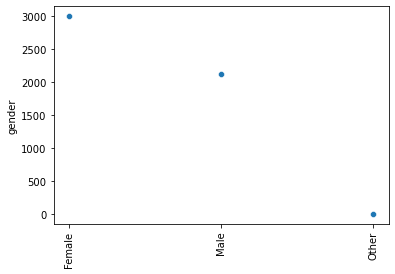

Graph for age: Total = 104


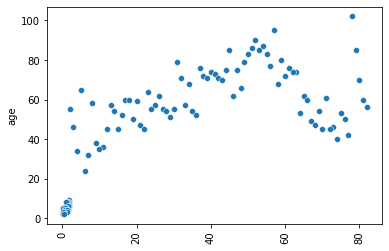

Graph for hypertension: Total = 2


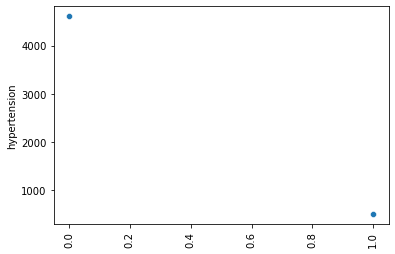

Graph for heart_disease: Total = 2


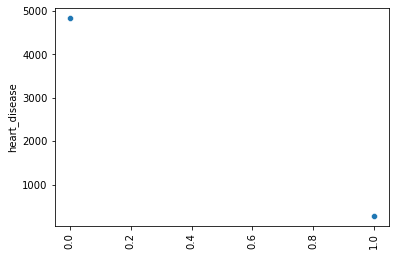

Graph for ever_married: Total = 2


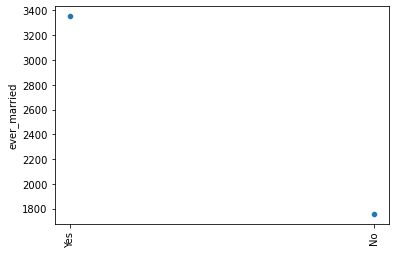

Graph for work_type: Total = 5


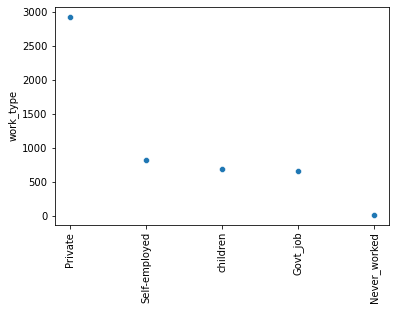

Graph for Residence_type: Total = 2


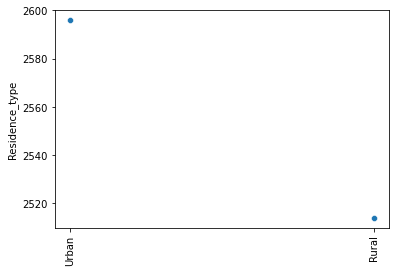

Graph for avg_glucose_level: Total = 3979


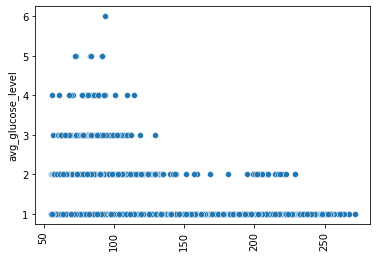

Graph for bmi: Total = 419


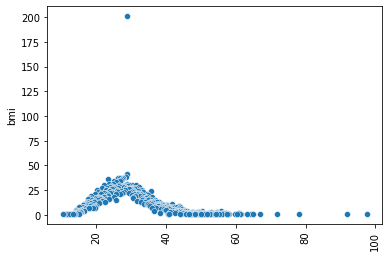

Graph for smoking_status: Total = 3


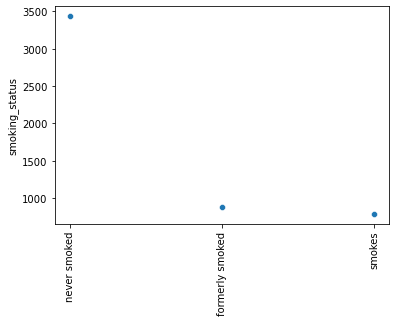

Graph for stroke: Total = 2


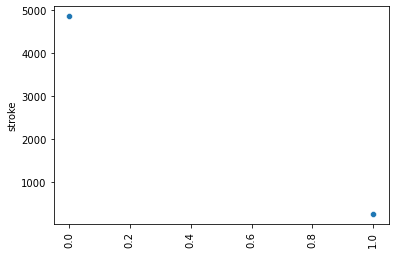

In [21]:
def plot_scatterplots():
    for i in cols_to_plot.columns:
        cat_num = cols_to_plot[i].value_counts()
        print(f'Graph for {i}: Total = {len(cat_num)}')
        sns.scatterplot(x=cat_num.index, y=cat_num)
        plt.xticks(rotation=90)
        plt.show()
        
        
plot_scatterplots()

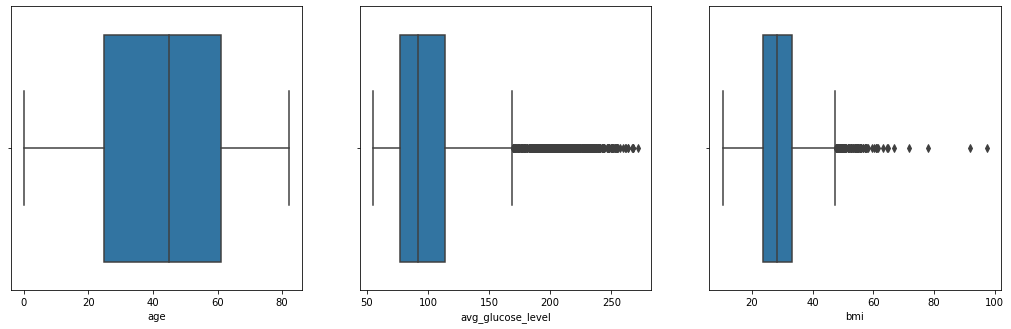

In [22]:
## Plot Boxplot For Numerical Columns to show distribution data & outliers value
df_outliers = df_eda.drop(columns = ['gender','hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type',
       'smoking_status', 'stroke'])

plt.figure(figsize =(24, 24))
x = 1 

for column in df_outliers.columns:
    plt.subplot(4,4,x)
    sns.boxplot(df_outliers[column])
    x+=1
    
plt.show()

- Avg Glucose Level and BMI have Outliers Value

In [23]:
outliers = []
def cek_outlier(data):
    sorted(data)
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3-q1
    lower_fence = q1 - (1.5 * iqr)
    upper_fence = q3 + (1.5 * iqr)
    for i in data:
        if i < lower_fence or i > upper_fence:
            outliers.append(i)
    return outliers

In [24]:
# function to get unique values
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
            
    return unique_list

In [25]:
outliers = []
cek_outlier(df_clean['bmi'])
print(len(outliers))
unique(outliers)

126


[48.9,
 47.5,
 56.6,
 50.1,
 54.6,
 60.9,
 54.7,
 48.2,
 64.8,
 47.3,
 46.5,
 46.6,
 49.8,
 60.2,
 51.0,
 51.5,
 71.9,
 50.2,
 47.8,
 55.7,
 57.5,
 54.2,
 52.3,
 50.3,
 78.0,
 53.4,
 55.2,
 48.4,
 50.6,
 49.5,
 55.0,
 54.8,
 52.8,
 66.8,
 55.1,
 48.5,
 55.9,
 57.3,
 10.3,
 56.0,
 51.8,
 57.7,
 49.3,
 54.0,
 56.1,
 97.6,
 53.9,
 49.4,
 49.2,
 48.7,
 53.8,
 48.8,
 52.7,
 53.5,
 50.5,
 51.9,
 63.3,
 61.2,
 48.0,
 46.8,
 48.3,
 58.1,
 50.4,
 59.7,
 47.4,
 52.5,
 52.9,
 61.6,
 49.9,
 54.3,
 47.9,
 50.9,
 57.2,
 64.4,
 92.0,
 50.8,
 57.9,
 47.6,
 46.4,
 46.9,
 47.1,
 48.1,
 51.7,
 46.3,
 54.1]

#### Initial thoughts on graphs above.
- gender - Drop 'Other' since it's only 1 data
- bmi - Drop data from >70 since it's too far from the others and only <10 data.

In [26]:
df_clean[df_clean.bmi >70]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
544,Male,42.00,0,0,Yes,Private,Rural,210.48,71.90,never smoked,0
928,Female,23.00,1,0,No,Private,Urban,70.03,78.00,smokes,0
2128,Male,17.00,1,0,No,Private,Rural,61.67,97.60,never smoked,0
4209,Male,38.00,1,0,Yes,Private,Rural,56.90,92.00,never smoked,0


In [27]:
df_clean[df_clean.gender == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.00,0,0,No,Private,Rural,143.33,22.40,formerly smoked,0


In [28]:
df_clean = df_clean[df_clean.bmi < 70]
df_clean = df_clean[~df_clean['gender'].str.contains('Other')]

In [29]:
df_clean.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.89,never smoked,1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


# DATA PREPARATION - FEATURES ENGINEERING

### FEATURES ENGINEERING FOR EDA

- Binning Glucose Level based on https://www.researchgate.net/figure/Blood-Glucose-Levels-Chart_tbl1_221776280
- Binning BMI based on https://www.euro.who.int/en/health-topics/disease-prevention/nutrition/a-healthy-lifestyle/body-mass-index-bmi
- Binning Age

#### Binning Avg Glucose Level

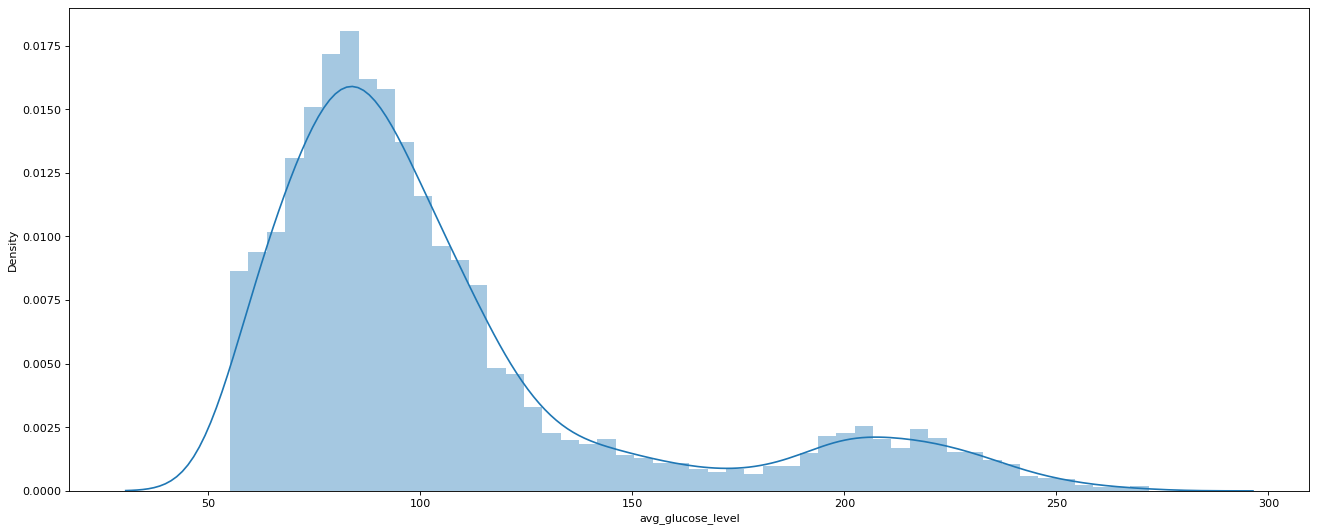

In [30]:
## Avg Glucose Level Distribution Data
plt.figure(figsize=(20,8), dpi = 80)
sns.distplot(df_clean['avg_glucose_level'])
plt.show()

In [31]:
df_clean['avg_glucose_level'].max()

271.74

In [32]:
glucose_bin = [55, 60, 80, 101, 126, df_clean['avg_glucose_level'].max()]
glucose_label = ['Hypoglycemia', 'Early Hypoglycemia', 'Normal', 'Early Diabetes', 'Diabetic']

df_clean['glucose_group'] = pd.cut(df_clean['avg_glucose_level'], bins = glucose_bin, labels = glucose_label)

#### Binning BMI

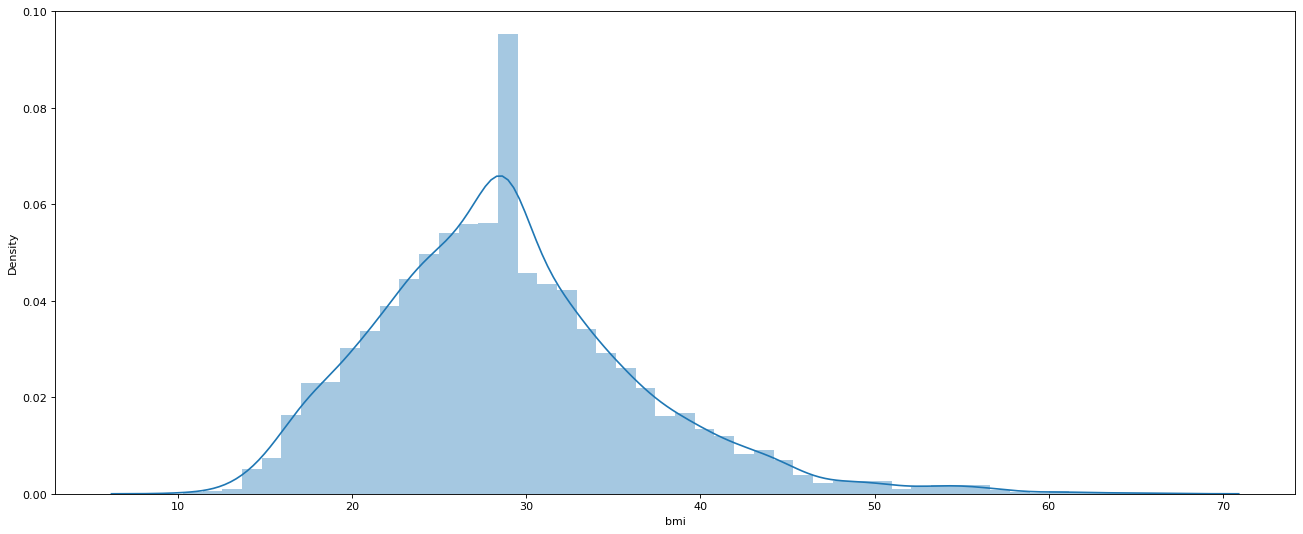

In [33]:
## BMI Level Distribution Data
plt.figure(figsize=(20,8), dpi = 80)
sns.distplot(df_clean['bmi'])
plt.show()

In [34]:
df_clean['bmi'].max()

66.8

In [35]:
bmi_bin = [10, 18.5, 25, 30, 35, 40, df_clean['bmi'].max()]
bmi_label = ['Underweight', 'Normal weight', 'Pre-obesity', 'Obesity class I', 'Obesity class II', 'Obesity class III']

df_clean['bmi_group'] = pd.cut(df_clean['bmi'], bins = bmi_bin, labels = bmi_label)

#### Binning Age

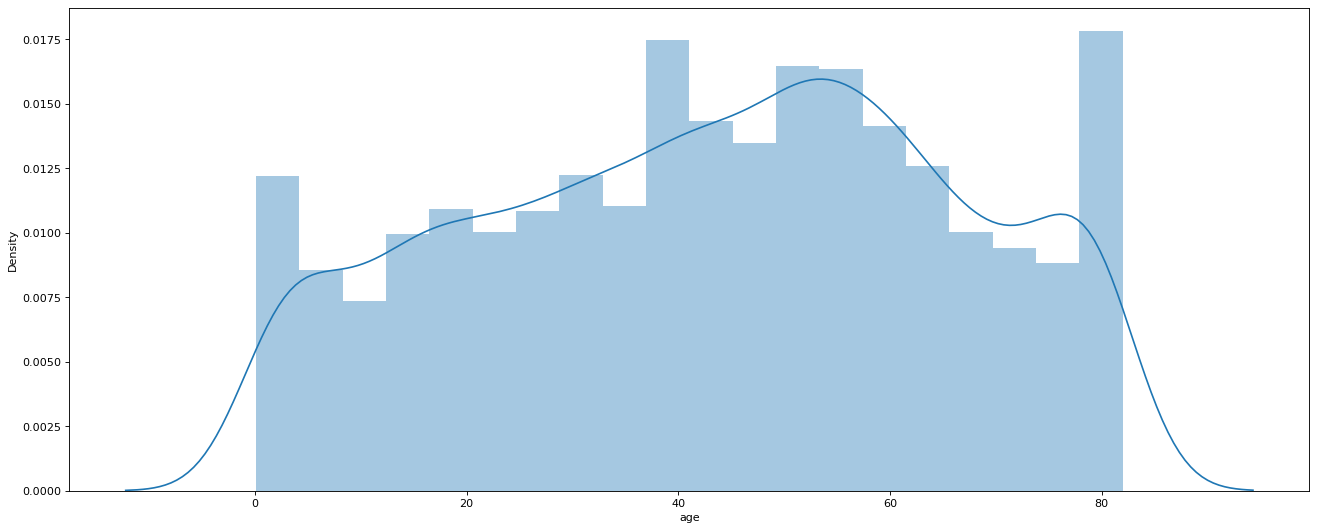

In [36]:
## Age Distribution Data
plt.figure(figsize=(20,8), dpi = 80)
sns.distplot(df_clean['age'])
plt.show()

In [37]:
age_bin = [0, 5, 17, 30, 45, 60, df_clean['age'].max()]
age_label = ['Baby', 'Children', 'Young Adults', 'Middle-Aged Adults', 'Old Adults', 'Elder']

df_clean['age_group'] = pd.cut(df_clean['age'], bins = age_bin , labels = age_label)

In [38]:
df_clean

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,glucose_group,bmi_group,age_group
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,Diabetic,Obesity class II,Elder
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.89,never smoked,1,Diabetic,Pre-obesity,Elder
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,Early Diabetes,Obesity class I,Elder
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,Diabetic,Obesity class I,Old Adults
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,Diabetic,Normal weight,Elder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.00,1,0,Yes,Private,Urban,83.75,28.89,never smoked,0,Normal,Pre-obesity,Elder
5106,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0,Early Diabetes,Obesity class II,Elder
5107,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0,Normal,Obesity class I,Middle-Aged Adults
5108,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0,Diabetic,Pre-obesity,Old Adults


# EXPLORATORY DATA ANALYSIS & DATA VISUALIZATION

##### Initial Hypothesis 
- Age affect Patient's status of stroke
- Smoking status affect Patient's status of stroke
- BMI affect Patient's status of stroke
- Glucose Level affect Patient's status of stroke
- Heart Disease affect Patient's status of stroke
- Hypertension affect Patient's status of stroke

### CORELLATION ANALYSIS

In [39]:
df_clean.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,glucose_group,bmi_group,age_group
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,Diabetic,Obesity class II,Elder
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.89,never smoked,1,Diabetic,Pre-obesity,Elder
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,Early Diabetes,Obesity class I,Elder
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,Diabetic,Obesity class I,Old Adults
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,Diabetic,Normal weight,Elder


### Association

In [40]:
df_aso = df_clean.drop(columns = ['age','avg_glucose_level', 'bmi'])

In [41]:
df_aso.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,glucose_group,bmi_group,age_group
0,Male,0,1,Yes,Private,Urban,formerly smoked,1,Diabetic,Obesity class II,Elder
1,Female,0,0,Yes,Self-employed,Rural,never smoked,1,Diabetic,Pre-obesity,Elder
2,Male,0,1,Yes,Private,Rural,never smoked,1,Early Diabetes,Obesity class I,Elder
3,Female,0,0,Yes,Private,Urban,smokes,1,Diabetic,Obesity class I,Old Adults
4,Female,1,0,Yes,Self-employed,Rural,never smoked,1,Diabetic,Normal weight,Elder


In [42]:
assoc_theils = []

for i in df_aso.columns:
    assoc = round(theils_u(df_aso['stroke'], df_clean[i]), 2)
    assoc_theils.append(assoc)

In [43]:
data_theils = pd.DataFrame(data = [assoc_theils], columns = df_aso.columns, index=['stroke'])

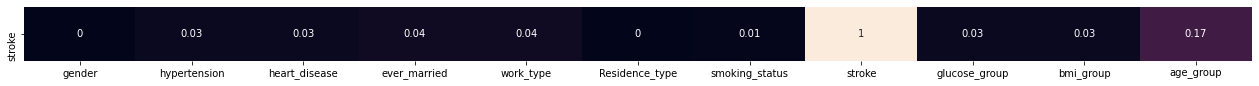

In [44]:
plt.figure(figsize=(22, 1))
sns.heatmap(data_theils, annot=True, cbar=False)
plt.show()

In [45]:
#recheck with more detailed data
df_clean.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.00,0.28,0.26,0.24,0.34,0.25
hypertension,0.28,1.00,0.11,0.18,0.15,0.13
heart_disease,0.26,0.11,1.00,0.16,0.04,0.13
avg_glucose_level,0.24,0.18,0.16,1.00,0.17,0.13
bmi,0.34,0.15,0.04,0.17,1.00,0.04
stroke,0.25,0.13,0.13,0.13,0.04,1.00


All features seems have low correlation value to patient's stroke status.
Age group is the highest, but only 0.17 (or 0.23 in non-groupped data)

In [40]:
## To ensure corelation, further analysis will be conducted

### UNIVARIATE ANALYSIS

#### Gender

In [41]:
df_clean['gender'].value_counts(normalize=True)

Female   0.59
Male     0.41
Name: gender, dtype: float64

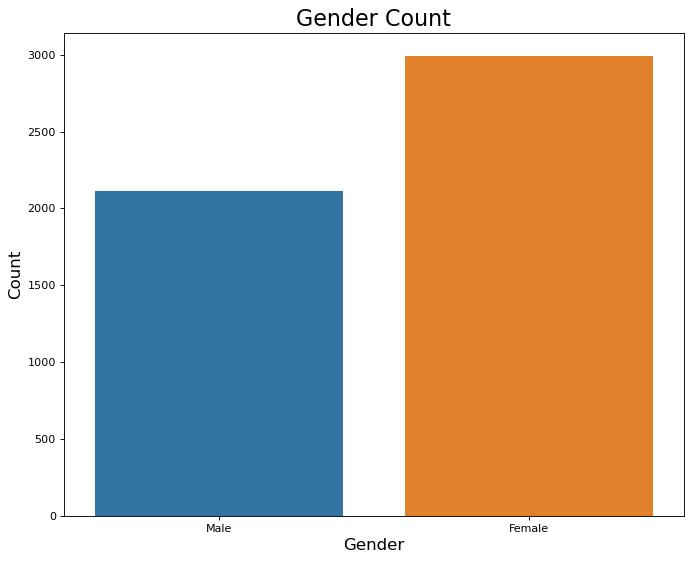

In [42]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['gender'])
plt.title('Gender Count', size =20)
plt.xlabel("Gender",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Majority patients is Female (59%)

#### Hypertension Status

In [43]:
df_clean['hypertension'].value_counts()

0    4611
1     498
Name: hypertension, dtype: int64

In [44]:
df_clean['hypertension'].value_counts(normalize=True)

0   0.90
1   0.10
Name: hypertension, dtype: float64

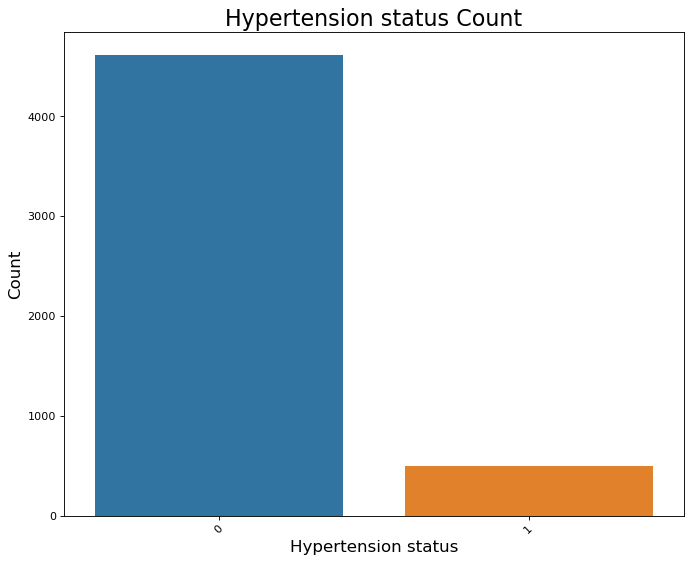

In [45]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['hypertension'])
plt.title('Hypertension status Count', size =20)
plt.xlabel("Hypertension status",size = 15)
plt.ylabel("Count", size = 15)
plt.xticks(rotation=45)
plt.show()

- 90% of patients are doesn't have hypertension

#### Age Group

In [46]:
df_clean['age_group'].value_counts()

Elder                 1304
Old Adults            1188
Middle-Aged Adults    1048
Young Adults           713
Children               536
Baby                   320
Name: age_group, dtype: int64

In [47]:
df_clean['age_group'].value_counts(normalize= True)

Elder                0.26
Old Adults           0.23
Middle-Aged Adults   0.21
Young Adults         0.14
Children             0.10
Baby                 0.06
Name: age_group, dtype: float64

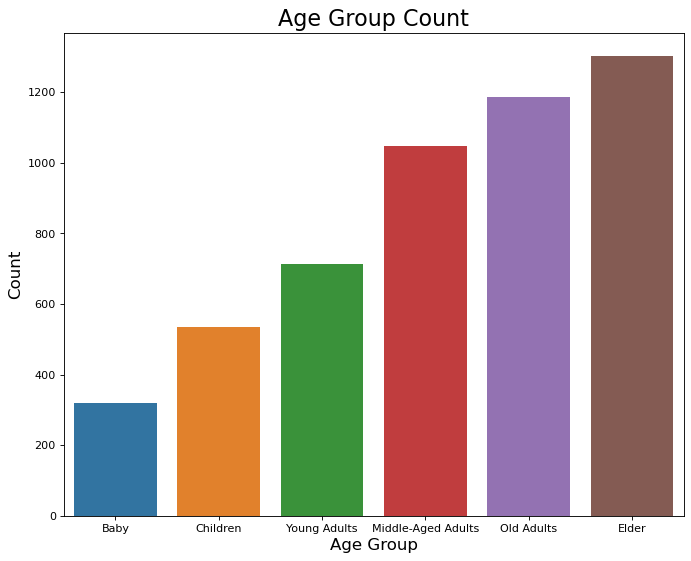

In [48]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['age_group'])
plt.title('Age Group Count', size =20)
plt.xlabel("Age Group",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Majority customers are Elder, but overall not so much different 

#### Heart Disease Status

In [49]:
df_clean['heart_disease'].value_counts()

0    4833
1     276
Name: heart_disease, dtype: int64

In [50]:
df_clean['heart_disease'].value_counts(normalize=True)

0   0.95
1   0.05
Name: heart_disease, dtype: float64

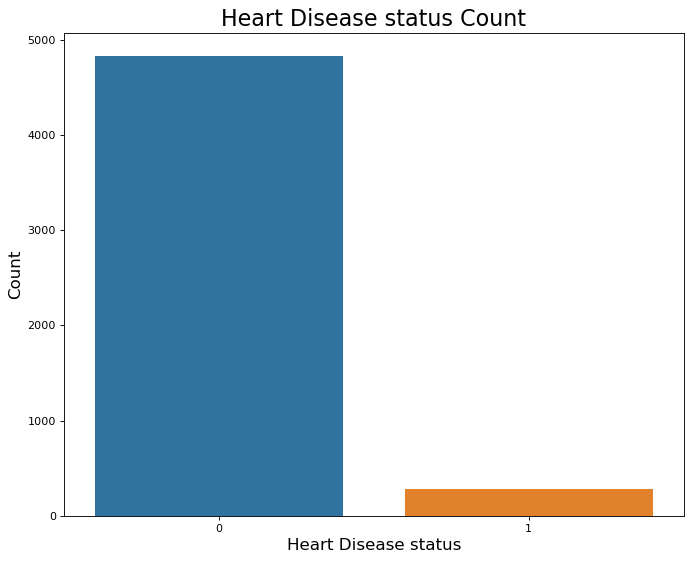

In [51]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['heart_disease'])
plt.title('Heart Disease status Count', size =20)
plt.xlabel("Heart Disease status",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- 95% patients don't have heart disease

#### Marriage status

In [52]:
df_clean['ever_married'].value_counts()

Yes    3353
No     1756
Name: ever_married, dtype: int64

In [53]:
df_clean['ever_married'].value_counts(normalize=True)

Yes   0.66
No    0.34
Name: ever_married, dtype: float64

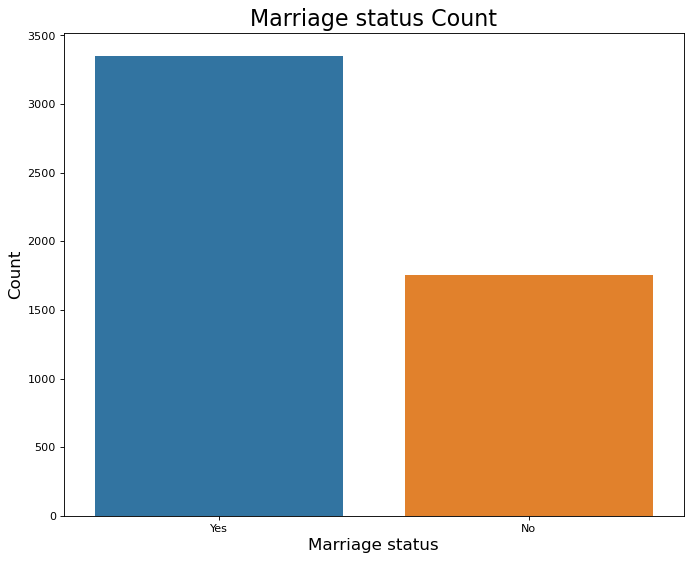

In [54]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['ever_married'])
plt.title('Marriage status Count', size =20)
plt.xlabel("Marriage status",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Majority patients have been married (66%)

#### Work Type

In [55]:
df_clean['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [56]:
df_clean['work_type'].value_counts(normalize=True)

Private         0.57
Self-employed   0.16
children        0.13
Govt_job        0.13
Never_worked    0.00
Name: work_type, dtype: float64

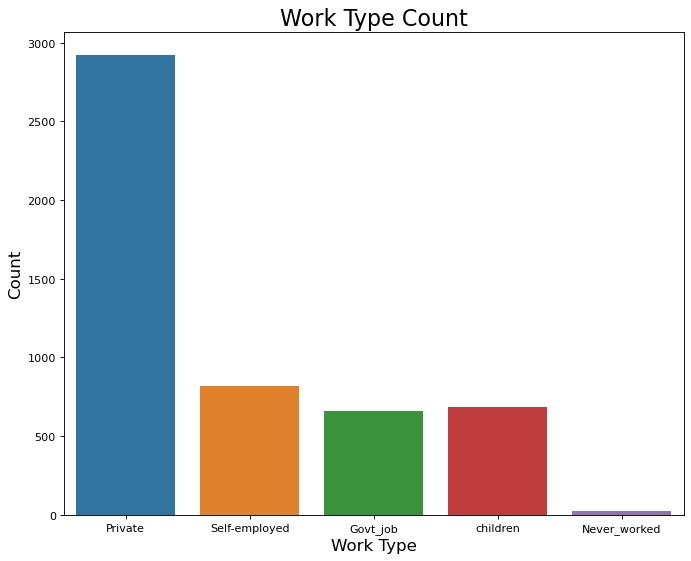

In [57]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['work_type'])
plt.title('Work Type Count', size =20)
plt.xlabel("Work Type",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Majority patients worked in private sector (57%)

#### Residence Type

In [58]:
df_clean['Residence_type'].value_counts()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

In [59]:
df_clean['Residence_type'].value_counts(normalize=True)

Urban   0.51
Rural   0.49
Name: Residence_type, dtype: float64

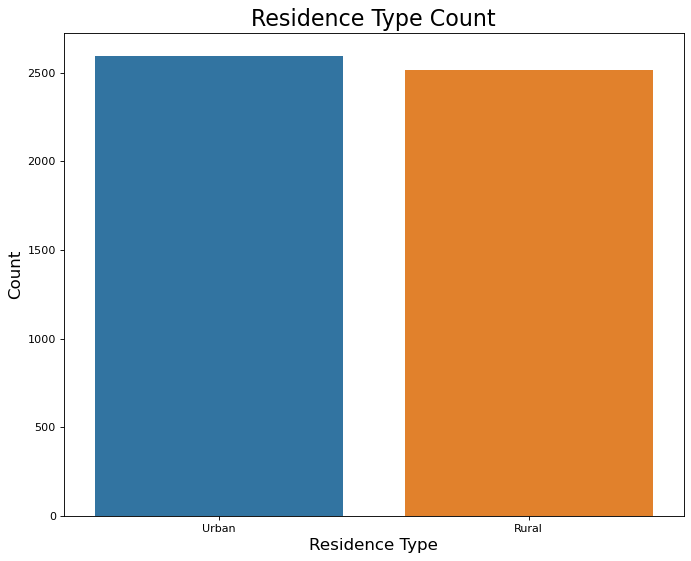

In [60]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['Residence_type'])
plt.title('Residence Type Count', size =20)
plt.xlabel("Residence Type",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Patient's residence type is pretty balanced

#### Smoking Status

In [101]:
df_clean['smoking_status'].value_counts()

never smoked       3436
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [102]:
df_clean['smoking_status'].value_counts(normalize=True)

never smoked      0.67
formerly smoked   0.17
smokes            0.15
Name: smoking_status, dtype: float64

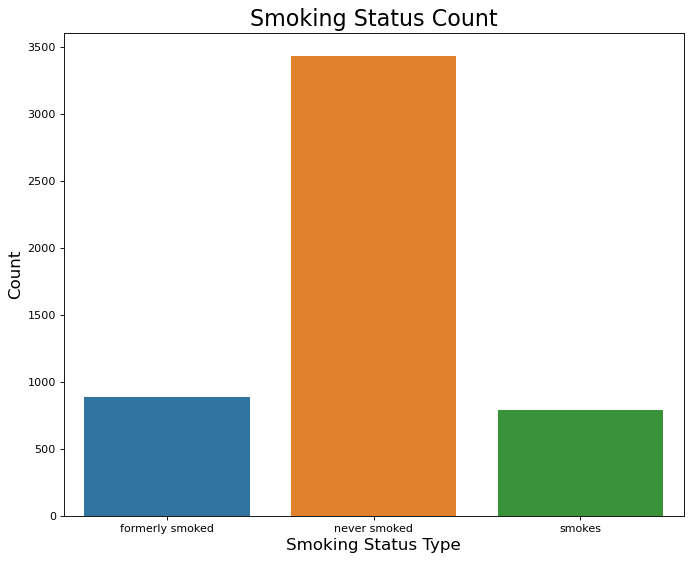

In [103]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['smoking_status'])
plt.title('Smoking Status Count', size =20)
plt.xlabel("Smoking Status Type",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Majority of the patiens never smoked (67%), while patients who smokes and formerly smoker has similar numbers

#### Glucose Status

In [64]:
df_clean['glucose_group'].value_counts()

Normal                1657
Early Hypoglycemia    1312
Diabetic               980
Early Diabetes         940
Hypoglycemia           220
Name: glucose_group, dtype: int64

In [65]:
df_clean['glucose_group'].value_counts(normalize=True)

Normal               0.32
Early Hypoglycemia   0.26
Diabetic             0.19
Early Diabetes       0.18
Hypoglycemia         0.04
Name: glucose_group, dtype: float64

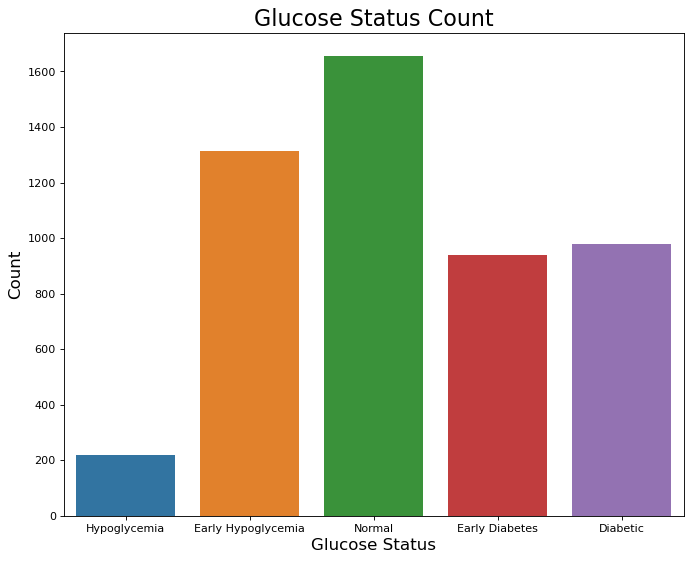

In [66]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['glucose_group'])
plt.title('Glucose Status Count', size =20)
plt.xlabel("Glucose Status",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Patients that been categorized Hypoglecemia has fewer numbers, while 'Normal' is the highest with 32%

#### BMI Status

In [67]:
df_clean['bmi_group'].value_counts()

Pre-obesity          1610
Normal weight        1257
Obesity class I       985
Obesity class II      500
Obesity class III     408
Underweight           349
Name: bmi_group, dtype: int64

In [68]:
df_clean['bmi_group'].value_counts(normalize=True)

Pre-obesity         0.32
Normal weight       0.25
Obesity class I     0.19
Obesity class II    0.10
Obesity class III   0.08
Underweight         0.07
Name: bmi_group, dtype: float64

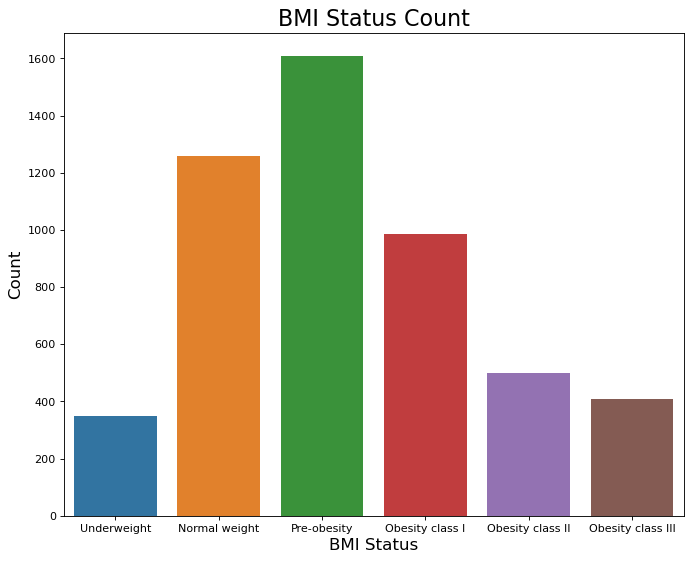

In [69]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['bmi_group'])
plt.title('BMI Status Count', size =20)
plt.xlabel("BMI Status",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Patients that been categorized Pre-obesity has highest numbers, similar with Normal (32% and 25% respectively)

#### Stroke Status

In [70]:
df_clean['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [71]:
df_clean['stroke'].value_counts(normalize=True)

0   0.95
1   0.05
Name: stroke, dtype: float64

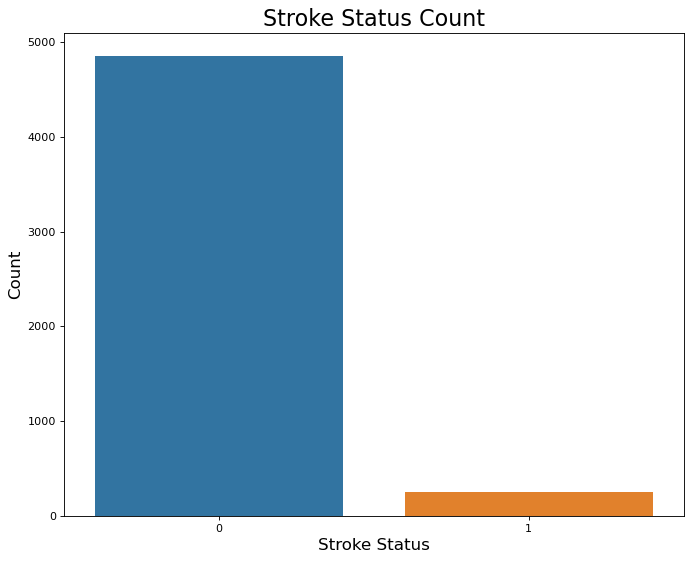

In [72]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df_clean['stroke'])
plt.title('Stroke Status Count', size =20)
plt.xlabel("Stroke Status",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Majority patients doesn't have stroke (95%). It's also show that this data is imbalanced

### MULTIVARIATE ANALYSIS
##### Initial Hypothesis 
- Age affect Patient's status of stroke
- Smoking status affect Patient's status of stroke
- BMI affect Patient's status of stroke
- Glucose Level affect Patient's status of stroke
- Heart Disease affect Patient's status of stroke
- Hypertension affect Patient's status of stroke

In [73]:
df_clean.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,glucose_group,bmi_group,age_group
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,Diabetic,Obesity class II,Elder
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.89,never smoked,1,Diabetic,Pre-obesity,Elder
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,Early Diabetes,Obesity class I,Elder
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,Diabetic,Obesity class I,Old Adults
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,Diabetic,Normal weight,Elder


#### Age VS Stroke Status

In [76]:
pd.crosstab(index = df_clean['age_group'], columns = df_clean['stroke'])

stroke,0,1
age_group,,
Baby,319,1
Children,535,1
Young Adults,713,0
Middle-Aged Adults,1037,11
Old Adults,1129,59
Elder,1127,177


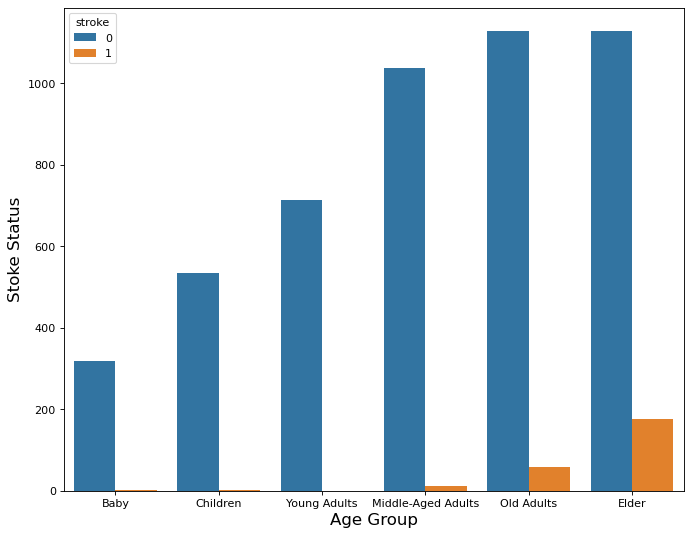

In [77]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('age_group', data = df_clean, hue = 'stroke')
plt.xlabel("Age Group",size = 15)
plt.ylabel("Stoke Status", size = 15)
plt.show()

- Patients who has stroke dominated by Elder with 71% of all patients that has stroke (177 from 249). Followed by Old Adults and Middle Aged
- Baby and Children only has 1 patients that has stroke. No Young-Adults suffer stroke

- If we compare patients's stroke status, Elder with stroke is 19% from all total Elder, Old Adults' is 4.9%, and Middle-Aged's is 1.04%
- From data above we can say that the older the patients, it has indication that it suffer stroke, compared with the younger patients.

#### Smoking status VS Stroke Status

In [104]:
pd.crosstab(index = df_clean['smoking_status'], columns = df_clean['stroke'])

stroke,0,1
smoking_status,,
formerly smoked,814,70
never smoked,3299,137
smokes,747,42


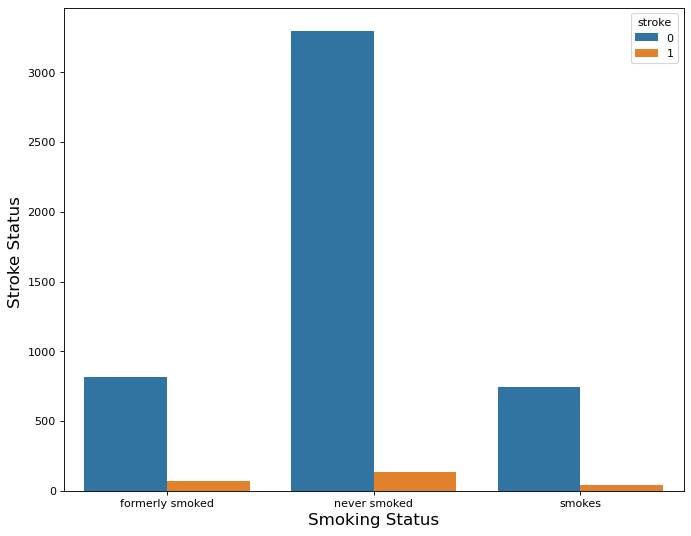

In [106]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('smoking_status', data = df_clean, hue = 'stroke')
plt.xlabel("Smoking Status",size = 15)
plt.ylabel("Stroke Status ", size = 15)
plt.show()

- Patients who has stroke dominated by Non-Smoker with 55% of all patients that has stroke (137 from 249). Followed by Formerly Smoker and Active Smoker

- If we compare patients's stroke status, Non-Smoker patients is 4.15% from all total Non-Smoker patiens, Former Smoker's is 8.6%, and Smoker's is 5.62%
- From data above we can say that smoking status not really affect the stroke status

#### BMI Status vs Stroke Status

In [113]:
pd.crosstab(index = df_clean['bmi_group'], columns = df_clean['stroke'])

stroke,0,1
bmi_group,,
Underweight,348,1
Normal weight,1220,37
Pre-obesity,1495,115
Obesity class I,931,54
Obesity class II,476,24
Obesity class III,390,18


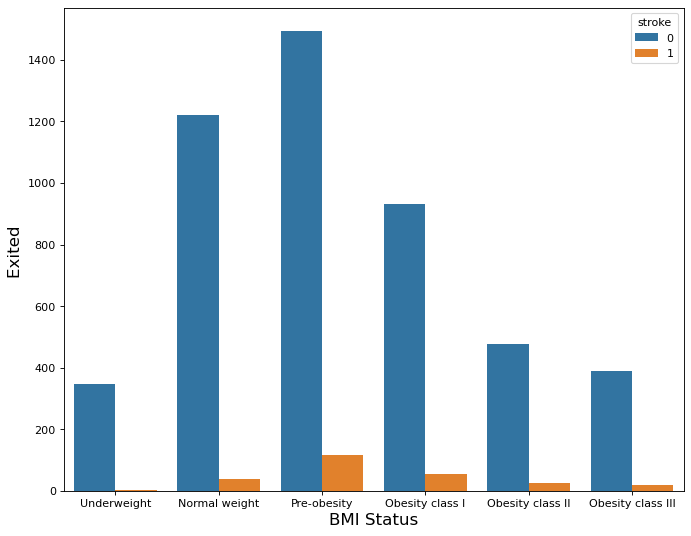

In [114]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('bmi_group', data = df_clean, hue = 'stroke')
plt.xlabel("BMI Status",size = 15)
plt.ylabel("Stroke Status ", size = 15)
plt.show()

- Patients who has stroke dominated by Pre-obesity with 46.18% of all patients that has stroke (115 from 249). Followed by Obesity class I and Normal

- If we compare patients's stroke status, Pre-obesity patients is 7.69% from all total Pre-obesity patiens, Former Obesity class I's is 5.8%, and Normal's is 3.03%
- From data above we can say that BMI status not really affect the stroke status

#### Glucose Status vs Stroke Status

In [121]:
pd.crosstab(index = df_clean['glucose_group'], columns = df_clean['stroke'])

stroke,0,1
glucose_group,,
Hypoglycemia,212,8
Early Hypoglycemia,1257,55
Normal,1607,50
Early Diabetes,904,36
Diabetic,880,100


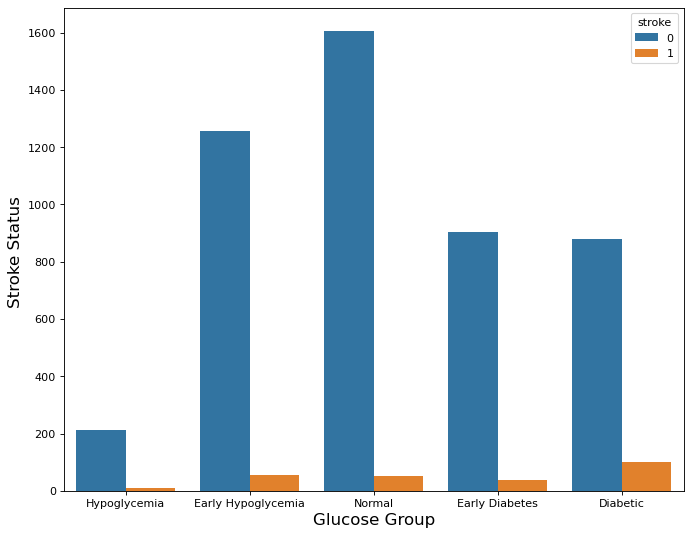

In [119]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('glucose_group', data = df_clean, hue = 'stroke')
plt.xlabel("Glucose Group",size = 15)
plt.ylabel("Stroke Status ", size = 15)
plt.show()

- Patients who has stroke dominated by Diabetic with 40.16% of all patients that has stroke (115 from 249). Hypoglycemia is the lowest (3.21%), while others has similar numbers

- From data above we can say that Glucose status have an affect but not much

#### Heart Disease VS Stroke Status

In [126]:
pd.crosstab(index = df_clean['heart_disease'], columns = df_clean['stroke'])

stroke,0,1
heart_disease,,
0,4631,202
1,229,47


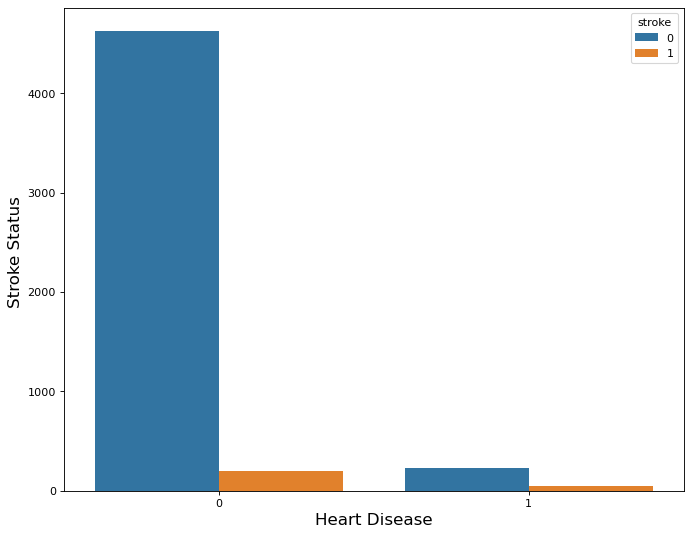

In [125]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('heart_disease', data = df_clean, hue = 'stroke')
plt.xlabel("Heart Disease",size = 15)
plt.ylabel("Stroke Status ", size = 15)
plt.show()

- Patients who has stroke dominated by non-heart disease patients with 81.12% of all patients that has stroke (202 from 249).

- If we compare patients's stroke status, non-heart disease patients is only 4.36% from all total Pre-obesity patiens, compared with patients that's also suffering from heart-disease is 20.52% from all patients that has heart disease

- From data above we can say that Heart Disease status may have an effect on Stroke Status

#### Hypertension vs Stroke Status

In [128]:
pd.crosstab(index = df_clean['hypertension'], columns = df_clean['stroke'])

stroke,0,1
hypertension,,
0,4428,183
1,432,66


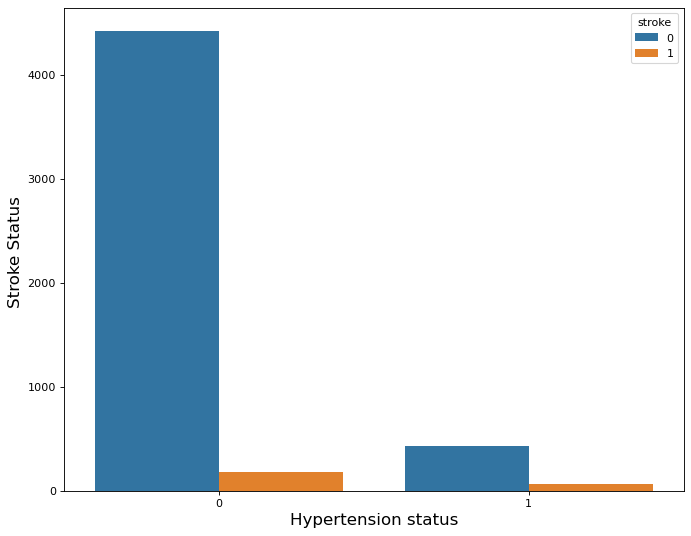

In [129]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('hypertension', data = df_clean, hue = 'stroke')
plt.xlabel("Hypertension status",size = 15)
plt.ylabel("Stroke Status ", size = 15)
plt.show()

- Patients who has stroke dominated by patients without hypertension with 73.49% of all patients that has stroke (183 from 249).
- If we compare patients's stroke status, patients without hypertension is only 4.13% from all total patients without hypertension, compared with patients with hypertension is 15.28% from all patients with hypertension
- From data above we can say that Hypertension status may have an effect on Stroke Status

# DATA INSIGHT

- Data is imbalanced, both in target and features
-	Majority patients is Female (59%)
-	90% of patients are doesn't have hypertension
-	Majority customers are Elder, but overall not so much different
-	95% patients don't have heart disease
-	Majority patients have been married (66%)
-	Majority patients worked in private sector (57%)
-	Majority of the patiens never smoked (67%),
-	Patients that been categorized Hypoglecemia has fewer numbers, while 'Normal' is the highest with 32%
-	Patients that been categorized Pre-obesity has highest numbers, similar with Normal (32% and 25% respectively)
-	Majority patients doesn't have stroke (95%). 

- All features don't have strong correlation value with the target.
-	Older Patients has indication they more suspectible to stroke
- Patients with Heart Disease status has indication they more suspectible to stroke
-  Patients with Hypertension status may have an effect on Stroke Status
-	Smoking status not really affect the stroke status
-	BMI status not really affect the stroke status
-	Glucose status have an affect but not much


# DATA MODELING

In [6]:
strokedesc = []

for i in df.columns:
    strokedesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        (((df[i].isna().sum()) / len(df)) * 100).round(2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

In [7]:
pd.DataFrame(data = strokedesc, columns= [
    'Data Feature',
    'Data Types',
    'Null',
    'Null Pct',
    'Unique',
    'Unique Sample'
] )

,Data Feature,Data Types,Null,Null Pct,Unique,Unique Sample
0,id,int64,0,0.00,5110,"[18072, 32221]"
1,gender,object,0,0.00,3,"[Male, Female]"
2,age,float64,0,0.00,104,"[37.0, 75.0]"
3,hypertension,int64,0,0.00,2,"[1, 0]"
4,heart_disease,int64,0,0.00,2,"[0, 1]"
5,ever_married,object,0,0.00,2,"[No, Yes]"
6,work_type,object,0,0.00,5,"[Private, Self-employed]"
7,Residence_type,object,0,0.00,2,"[Urban, Rural]"
8,avg_glucose_level,float64,0,0.00,3979,"[81.06, 120.22]"
9,bmi,float64,201,3.93,418,"[25.8, 37.4]"


In [30]:
df_eda.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [31]:
pd.DataFrame(data = strokedesc, columns= [
    'Data Feature',
    'Data Types',
    'Null',
    'Null Pct',
    'Unique',
    'Unique Sample'
] )

,Data Feature,Data Types,Null,Null Pct,Unique,Unique Sample
0,id,int64,0,0.00,5110,"[35188, 12345]"
1,gender,object,0,0.00,3,"[Female, Male]"
2,age,float64,0,0.00,104,"[45.0, 1.08]"
3,hypertension,int64,0,0.00,2,"[1, 0]"
4,heart_disease,int64,0,0.00,2,"[0, 1]"
5,ever_married,object,0,0.00,2,"[Yes, No]"
6,work_type,object,0,0.00,5,"[Private, Govt_job]"
7,Residence_type,object,0,0.00,2,"[Rural, Urban]"
8,avg_glucose_level,float64,0,0.00,3979,"[216.07, 243.73]"
9,bmi,float64,201,3.93,418,"[13.5, 31.4]"


In [20]:
# df['ever_married'] = df['ever_married'].map({'Yes' :1, 'No':0})
# df['work_type'] = df['work_type'].map({'children' :0, 'Never_worked':1, 'Self-employed': 2, 'Private' : 3, 'Govt_job' : 4 })
# df['gender'] = df['gender'].map({'Other' :0, 'Male':1, 'Female' : 2})
# df['Residence_type'] = df['Residence_type'].map({'Rural' :0, 'Urban':1})
# df['smoking_status'] = df['smoking_status'].map({'Unknown' :0, 'never smoked':1, 'formerly smoked': 2, 'smokes' : 3,})
df_eda = df_eda[~df_eda['gender'].str.contains('Other')]

In [21]:
## Splitting data
X = df_eda.drop(columns=['stroke'])
y = df_eda['stroke']

In [22]:
X_train, X_test, y_train,y_test = train_test_split(X,y,stratify=y, test_size= .20, random_state=420)

In [23]:
X_train.shape

(4087, 10)

In [24]:
X_test.shape

(1022, 10)

In [25]:
df_eda.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [26]:
df_eda.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,nan,never smoked,1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [27]:
# num_columns = ['enrollee_id','city_development_index', 'training_hours']
num_columns = ['age', 'avg_glucose_level', 'bmi',]

cat_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
               'work_type', 'Residence_type']

# cat_scaling = ['smoking_status']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# numeric_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=3, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
# ])


categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder()),
])

# categoric_pipeline_scaling = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('encoder', OneHotEncoder()),
#     ('scaler', StandardScaler())
# ])

# preprocessor = ColumnTransformer([
#     ('numeric', numeric_pipeline, num_columns),
#     ('categorical', categoric_pipeline, cat_columns),
#     ('categorical scaling', categoric_pipeline_scaling, cat_scaling)
# ])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns),
])


pipe_RF = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(class_weight='balanced'))
])

pipe_SVM = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC(probability=True, class_weight = 'balanced'))
])

pipe_KNN = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier(weights = 'uniform'))
])

pipe_LR = Pipeline([
    ("prep", preprocessor),
    ("algo", LogisticRegression(class_weight ='balanced'))
])

## Random Forest

In [28]:
pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                              

In [29]:
y_pred_RF_tr = pipe_RF.predict(X_train)

In [30]:
print(classification_report(y_train, y_pred_RF_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3888
           1       1.00      1.00      1.00       199

    accuracy                           1.00      4087
   macro avg       1.00      1.00      1.00      4087
weighted avg       1.00      1.00      1.00      4087



In [31]:
y_pred_RF_ts = pipe_RF.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred_RF_ts))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.50      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.73      0.51      0.51      1022
weighted avg       0.93      0.95      0.93      1022



In [33]:
cm_RF = confusion_matrix(y_test, y_pred_RF_ts, labels=[0, 1])

In [34]:
df_RF = pd.DataFrame(cm_RF, index=['Akt Atr', 'Akt Exist'], columns = ['Pred Atr', 'Pred Exist'])
df_RF

,Pred Atr,Pred Exist
Akt Atr,971,1
Akt Exist,49,1


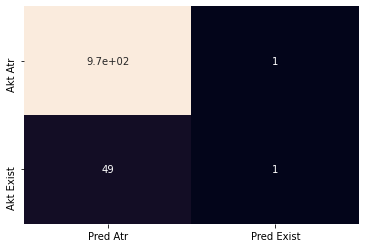

In [35]:
sns.heatmap(df_RF, annot=True, cbar=False)
plt.show()

### Random Forest Hypertuning Parameter

In [37]:
pipe_RF.get_params()

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    ['age', 'avg_glucose_level', 'bmi']),
                                   ('categorical',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('encoder', OneHotEncoder())]),
                                    ['gender', 'hypertension', 'heart_disease',
                                     'ever_married', 'work_type',
                                     'Residence_type'])])),
  ('algo', RandomForestClassifier(class_weight='balanced'))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(st

In [48]:
param_RF = {
    'algo__n_estimators' : np.arange(100,501,200),
    'algo__max_depth' : [None, 5, 10, 25, 50],
#     "prep__numeric__poly__degree" : [2, 3, 4],
    'algo__min_samples_leaf' : np.arange(1,101, 50),
    'algo__max_features' : [0.3,0.5,0.7],
    "algo__class_weight" : [{0:x, 1: 1 - x} for x in [.1, .20, .35, .40]]
#      "algo__class_weight" : [{0:x, 1: 1 - x} for x in [.1, .20, .35, .40]]
}

In [49]:
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle = True, )

In [54]:
RF_RS= RandomizedSearchCV(pipe_RF, param_RF, cv=skf, n_iter=50, n_jobs=-1, verbose=1, random_state=42, scoring='recall')

In [55]:
RF_RS.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   29.5s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'avg_glucose_level',
                                                                                'bmi']),
                                                     

In [56]:
RF_RS.best_params_

{'algo__n_estimators': 300,
 'algo__min_samples_leaf': 51,
 'algo__max_features': 0.5,
 'algo__max_depth': 50,
 'algo__class_weight': {0: 0.1, 1: 0.9}}

In [57]:
RF_Tuned_RS = RF_RS.best_estimator_

In [59]:
y_ts_RF1 = RF_Tuned_RS.predict(X_test)

In [60]:
print(classification_report(y_test, y_ts_RF1))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       972
           1       0.19      0.60      0.28        50

    accuracy                           0.85      1022
   macro avg       0.58      0.73      0.60      1022
weighted avg       0.94      0.85      0.89      1022



In [61]:
cm_RF1_Tuned = confusion_matrix(y_test, y_ts_RF1, labels=[1, 0])

In [62]:
df_RF1_Tuned = pd.DataFrame(cm_RF1_Tuned, index=['Akt 1', 'Akt 0'], columns =  ['Pred 1', 'Pred 0'])
df_RF1_Tuned

,Pred 1,Pred 0
Akt 1,30,20
Akt 0,132,840


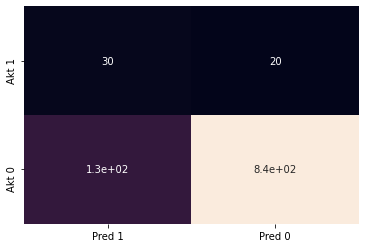

In [63]:
sns.heatmap(df_RF1_Tuned, annot=True, cbar=False)
plt.show()

### Random Forest - Fine Tuning

In [73]:
param_RF2 = {
    'algo__n_estimators' : np.arange(200,800,200),
    'algo__max_depth' : [45, 50, 55],
#     "prep__numeric__poly__degree" : [2, 3, 4],
    'algo__min_samples_leaf' : [25, 50, 75],
    'algo__max_features' : [0.4, 0.45 ,0.5, 0.55, 0.6],
    "algo__class_weight" : [{0: 0.1, 1: 0.9}]
#      "algo__class_weight" : [{0:x, 1: 1 - x} for x in [.1, .20, .35, .40]]
}

In [74]:
# {'algo__n_estimators': 300,
#  'algo__min_samples_leaf': 51,
#  'algo__max_features': 0.5,
#  'algo__max_depth': 50,
#  'algo__class_weight': {0: 0.1, 1: 0.9}}

In [75]:
RF_GS = GridSearchCV(pipe_RF, param_RF2, cv = skf, scoring = 'recall', n_jobs = -1, verbose=1)

In [76]:
RF_GS.fit(X_train,y_train)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('categorical',
                         

In [77]:
RF_GS.best_params_

{'algo__class_weight': {0: 0.1, 1: 0.9},
 'algo__max_depth': 45,
 'algo__max_features': 0.6,
 'algo__min_samples_leaf': 75,
 'algo__n_estimators': 600}

In [78]:
RF_Tuned_GS = RF_GS.best_estimator_

In [81]:
y_ts_RF2 = RF_Tuned_GS.predict(X_test)

In [82]:
print(classification_report(y_test, y_ts_RF2))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       972
           1       0.17      0.60      0.27        50

    accuracy                           0.84      1022
   macro avg       0.57      0.73      0.59      1022
weighted avg       0.94      0.84      0.88      1022



In [83]:
cm_RF2_Tuned = confusion_matrix(y_test, y_ts_RF2, labels=[1, 0])

In [84]:
df_RF2_Tuned = pd.DataFrame(cm_RF2_Tuned, index=['Akt 1', 'Akt 0'], columns =  ['Pred 1', 'Pred 0'])
df_RF2_Tuned

,Pred 1,Pred 0
Akt 1,30,20
Akt 0,144,828


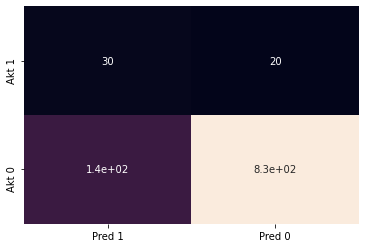

In [86]:
sns.heatmap(df_RF2_Tuned, annot=True, cbar=False)
plt.show()

### Random Forest - Fine Tuning 2

In [438]:
param_RF3 = {
    'algo__n_estimators' : [4251],
    'algo__max_depth' : [46],
#     "prep__numeric__poly__degree" : [2, 3, 4],
    'algo__min_samples_leaf' : [151],
    'algo__max_features' : [0.65],
    "algo__class_weight" : [{0: 0.055, 1: 0.945}]
#      "algo__class_weight" : [{0:x, 1: 1 - x} for x in [.1, .20, .35, .40]]
}

In [439]:
# {'algo__class_weight': {0: 0.1, 1: 0.9},
#  'algo__max_depth': 46,
#  'algo__max_features': 0.65,
#  'algo__min_samples_leaf': 151,
#  'algo__n_estimators': 4251}

In [440]:
RF_GS2 = GridSearchCV(pipe_RF, param_RF3, cv = skf, scoring = 'recall', n_jobs = -1, verbose=1)

In [441]:
RF_GS2.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('categorical',
                        

In [442]:
RF_GS2.best_params_

{'algo__class_weight': {0: 0.055, 1: 0.945},
 'algo__max_depth': 46,
 'algo__max_features': 0.65,
 'algo__min_samples_leaf': 151,
 'algo__n_estimators': 4251}

In [443]:
RF_Tuned_GS2 = RF_GS2.best_estimator_

In [444]:
y_ts_RF3 = RF_Tuned_GS2.predict(X_test)

In [445]:
print(classification_report(y_test, y_ts_RF3))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.15      0.78      0.25        50

    accuracy                           0.77      1022
   macro avg       0.57      0.77      0.55      1022
weighted avg       0.94      0.77      0.83      1022



In [446]:
cm_RF3_Tuned = confusion_matrix(y_test, y_ts_RF3, labels=[1, 0])

In [447]:
df_RF3_Tuned = pd.DataFrame(cm_RF3_Tuned, index=['Akt 1', 'Akt 0'], columns =  ['Pred 1', 'Pred 0'])
df_RF3_Tuned

,Pred 1,Pred 0
Akt 1,39,11
Akt 0,229,743


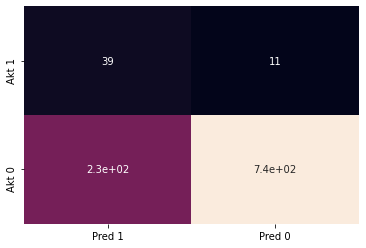

In [448]:
sns.heatmap(df_RF3_Tuned, annot=True, cbar=False)
plt.show()

# SVM

In [245]:
pipe_SVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                              

In [252]:
y_SVM1 = pipe_SVM.predict(X_test)

In [253]:
print(classification_report(y_test, y_svm))

              precision    recall  f1-score   support

           0       0.98      0.76      0.85       972
           1       0.13      0.72      0.22        50

    accuracy                           0.75      1022
   macro avg       0.56      0.74      0.54      1022
weighted avg       0.94      0.75      0.82      1022



In [254]:
cm_SVM1_Tuned = confusion_matrix(y_test, y_SVM1, labels=[1, 0])

In [255]:
df_SVM1_Tuned = pd.DataFrame(cm_SVM1_Tuned, index=['Akt 1', 'Akt 0'], columns =  ['Pred 1', 'Pred 0'])
df_SVM1_Tuned

,Pred 1,Pred 0
Akt 1,36,14
Akt 0,238,734


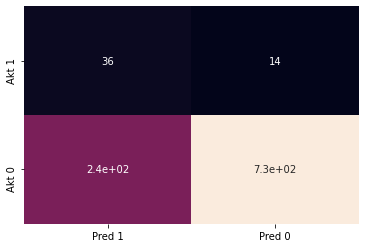

In [256]:
sns.heatmap(df_SVM1_Tuned, annot=True, cbar=False)
plt.show()

### SVM Hypertuning Parameter

In [257]:
pipe_SVM.get_params()

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    ['age', 'avg_glucose_level', 'bmi']),
                                   ('categorical',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('encoder', OneHotEncoder())]),
                                    ['gender', 'hypertension', 'heart_disease',
                                     'ever_married', 'work_type',
                                     'Residence_type'])])),
  ('algo', SVC(class_weight='balanced', probability=True))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(ste

In [259]:
param_SVM = {
    'algo__C' : np.logspace(-3 , 3, 7), #semakin tinggi, semakin kompleks. kalau overfit, kurangin nilai C
    "algo__gamma" : np.arange(10, 101, 25), #semakin tinggi, semakin kompleks. kalau overfit, kurangin nilai gamma
    "algo__class_weight" : [{0:x, 1: 1 - x} for x in [.1, .20, .35, .40]]
}

In [260]:
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle = True, )

In [261]:
SVM_RS= RandomizedSearchCV(pipe_SVM, param_SVM, cv=skf, n_iter=50, n_jobs=-1, verbose=1, random_state=42, scoring='recall')

In [262]:
SVM_RS.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   59.8s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'avg_glucose_level',
                                                                                'bmi']),
                                                     

In [263]:
SVM_RS.best_params_

{'algo__gamma': 10, 'algo__class_weight': {0: 0.1, 1: 0.9}, 'algo__C': 10.0}

In [264]:
SVM_Tuned_RS = SVM_RS.best_estimator_

In [265]:
y_ts_SVM1 = SVM_Tuned_RS.predict(X_test)

In [268]:
print(classification_report(y_test, y_ts_SVM1))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.05      0.02      0.03        50

    accuracy                           0.93      1022
   macro avg       0.50      0.50      0.50      1022
weighted avg       0.91      0.93      0.92      1022



In [269]:
cm_SVM1_Tuned = confusion_matrix(y_test, y_ts_SVM1, labels=[1, 0])

In [270]:
df_SVM1_Tuned = pd.DataFrame(cm_SVM1_Tuned, index=['Akt 1', 'Akt 0'], columns =  ['Pred 1', 'Pred 0'])
df_SVM1_Tuned

,Pred 1,Pred 0
Akt 1,1,49
Akt 0,19,953


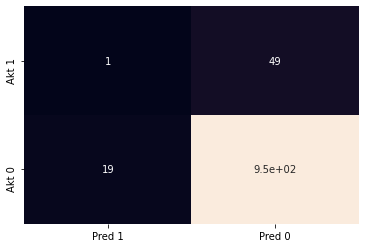

In [271]:
sns.heatmap(df_SVM1_Tuned, annot=True, cbar=False)
plt.show()

### SVM - Fine Tuning

In [272]:
param_SVM2 = {
    'algo__C' : np.logspace(-3 , 3, 7), #semakin tinggi, semakin kompleks. kalau overfit, kurangin nilai C
    "algo__gamma" : np.arange(10, 20, 2), #semakin tinggi, semakin kompleks. kalau overfit, kurangin nilai gamma
    "algo__class_weight" : [{0: 0.1, 1: 0.9}]
}

In [ ]:
# {'algo__gamma': 10, 'algo__class_weight': {0: 0.1, 1: 0.9}, 'algo__C': 10.0}

In [273]:
SVM_GS = GridSearchCV(pipe_SVM, param_SVM2, cv = skf, scoring = 'recall', n_jobs = -1, verbose=1)

In [274]:
SVM_GS.fit(X_train, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   35.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('categorical',
                         

In [275]:
SVM_GS.best_params_

{'algo__C': 10.0, 'algo__class_weight': {0: 0.1, 1: 0.9}, 'algo__gamma': 10}

In [276]:
SVM_Tuned_GS = SVM_GS.best_estimator_

In [277]:
y_ts_SVM2 = SVM_Tuned_GS.predict(X_test)

In [278]:
print(classification_report(y_test, y_ts_SVM2))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.05      0.02      0.03        50

    accuracy                           0.93      1022
   macro avg       0.50      0.50      0.50      1022
weighted avg       0.91      0.93      0.92      1022



In [280]:
cm_SVM2_Tuned = confusion_matrix(y_test, y_ts_SVM2, labels=[1, 0])

In [281]:
df_SVM2_Tuned = pd.DataFrame(cm_SVM2_Tuned, index=['Akt 1', 'Akt 0'], columns =  ['Pred 1', 'Pred 0'])
df_SVM2_Tuned

,Pred 1,Pred 0
Akt 1,1,49
Akt 0,19,953


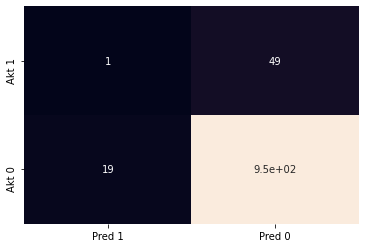

In [282]:
sns.heatmap(df_SVM2_Tuned, annot=True, cbar=False)
plt.show()

### SVM - Fine Tuning 2

In [328]:
param_SVM3 = {
    'algo__C' : np.logspace(-3 , 3, 3), #semakin tinggi, semakin kompleks. kalau overfit, kurangin nilai C
    "algo__gamma" : np.arange(0.03, 0.1, 0.01), #semakin tinggi, semakin kompleks. kalau overfit, kurangin nilai gamma
    "algo__class_weight" : [{0: 0.07, 1: 0.93}]
}

In [329]:
# {'algo__C': 1.0, 'algo__class_weight': {0: 0.05, 1: 0.95}, 'algo__gamma': 0.01}

In [330]:
SVM_GS3 = GridSearchCV(pipe_SVM, param_SVM3, cv = skf, scoring = 'recall', n_jobs = -1, verbose=1)

In [331]:
SVM_GS3.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   16.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('categorical',
                         

In [332]:
SVM_GS3.best_params_

{'algo__C': 1.0, 'algo__class_weight': {0: 0.07, 1: 0.93}, 'algo__gamma': 0.05}

In [333]:
SVM_Tuned_GS3 = SVM_GS3.best_estimator_

In [334]:
y_ts_SVM3 = SVM_Tuned_GS3.predict(X_test)

In [335]:
print(classification_report(y_test, y_ts_SVM3))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87       972
           1       0.15      0.78      0.25        50

    accuracy                           0.78      1022
   macro avg       0.57      0.78      0.56      1022
weighted avg       0.94      0.78      0.84      1022



In [336]:
cm_SVM3_Tuned = confusion_matrix(y_test, y_ts_SVM3, labels=[1, 0])

In [337]:
df_SVM3_Tuned = pd.DataFrame(cm_SVM3_Tuned, index=['Akt 1', 'Akt 0'], columns =  ['Pred 1', 'Pred 0'])
df_SVM3_Tuned

,Pred 1,Pred 0
Akt 1,39,11
Akt 0,218,754


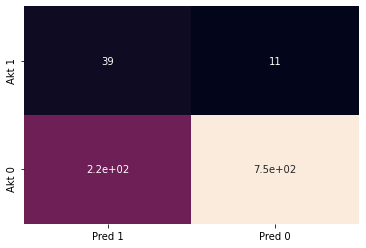

In [338]:
sns.heatmap(df_SVM3_Tuned, annot=True, cbar=False)
plt.show()

## KNN Classifier

In [339]:
pipe_KNN.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                              

In [340]:
y_KNN = pipe_KNN.predict(X_test)

In [341]:
print(classification_report(y_test, y_KNN))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       0.67      0.04      0.08        50

    accuracy                           0.95      1022
   macro avg       0.81      0.52      0.53      1022
weighted avg       0.94      0.95      0.93      1022



### KNN Hypertuning Parameter

In [342]:
pipe_KNN.get_params()

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    ['age', 'avg_glucose_level', 'bmi']),
                                   ('categorical',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('encoder', OneHotEncoder())]),
                                    ['gender', 'hypertension', 'heart_disease',
                                     'ever_married', 'work_type',
                                     'Residence_type'])])),
  ('algo', KNeighborsClassifier())],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('imputer', SimpleIm

In [343]:
param_KNN = {
    "algo__n_neighbors" : np.arange(1, 51, 2),
    "algo__p" : [1, 2],
    'algo__weights' : ['uniform', 'distance']
}

In [344]:
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle = True, )

In [346]:
KNN_RS= RandomizedSearchCV(pipe_KNN , param_KNN, cv=skf, n_iter=50, n_jobs=-1, verbose=1, random_state=42, scoring='recall')

In [347]:
KNN_RS.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.8s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'avg_glucose_level',
                                                                                'bmi']),
                                                     

In [348]:
KNN_RS.best_params_

{'algo__weights': 'uniform', 'algo__p': 1, 'algo__n_neighbors': 1}

In [349]:
KNN_Tuned_RS = KNN_RS.best_estimator_

In [350]:
y_ts_KNN1 = KNN_Tuned_RS.predict(X_test)

In [351]:
print(classification_report(y_test, y_ts_KNN1))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       972
           1       0.11      0.10      0.10        50

    accuracy                           0.91      1022
   macro avg       0.53      0.53      0.53      1022
weighted avg       0.91      0.91      0.91      1022



In [353]:
cm_KNN1_Tuned = confusion_matrix(y_test, y_ts_KNN1, labels=[1, 0])

In [354]:
df_KNN1_Tuned = pd.DataFrame(cm_KNN1_Tuned, index=['Akt 1', 'Akt 0'], columns =  ['Pred 1', 'Pred 0'])
df_KNN1_Tuned

,Pred 1,Pred 0
Akt 1,5,45
Akt 0,42,930


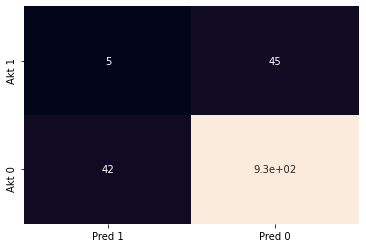

In [355]:
sns.heatmap(df_KNN1_Tuned, annot=True, cbar=False)
plt.show()

### KNN - Fine Tuning

In [390]:
param_KNN2 = {
    "algo__n_neighbors" : np.arange(1, 5, 1),
    "algo__p" : [1, 2, 3],
    'algo__weights' : ['uniform']
}

In [391]:
# {'algo__weights': 'uniform', 'algo__p': 1, 'algo__n_neighbors': 1}

In [392]:
skf = StratifiedKFold(n_splits=3, random_state=42)

In [393]:
KNN_GS = GridSearchCV(pipe_KNN, param_KNN2, cv = skf, scoring = 'recall', n_jobs = -1, verbose=1)

In [394]:
KNN_GS.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('categorical',
                        

In [399]:
KNN_GS.best_params_

{'algo__n_neighbors': 1, 'algo__p': 2, 'algo__weights': 'uniform'}

In [400]:
KNN2_Tuned = KNN_GS.best_estimator_

In [401]:
y_ts_KNN2 = KNN2_Tuned.predict(X_test)

In [402]:
print(classification_report(y_test, y_ts_KNN2))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       972
           1       0.12      0.12      0.12        50

    accuracy                           0.92      1022
   macro avg       0.54      0.54      0.54      1022
weighted avg       0.91      0.92      0.92      1022



In [403]:
cm_KNN2_Tuned = confusion_matrix(y_test, y_ts_KNN2, labels=[1, 0])

In [404]:
df_KNN2_Tuned = pd.DataFrame(cm_KNN2_Tuned, index=['Akt 1', 'Akt 0'], columns =  ['Pred 1', 'Pred 0'])
df_KNN2_Tuned

,Pred 1,Pred 0
Akt 1,6,44
Akt 0,42,930


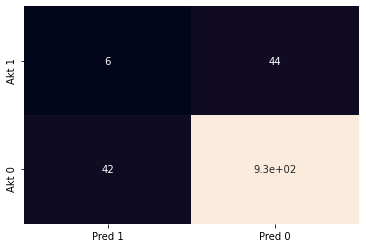

In [405]:
sns.heatmap(df_KNN2_Tuned, annot=True, cbar=False)
plt.show()

# Summary

- Since our objection is to detect patients who might be suffering stroke symptoms, we focused on lowering False Negative number as act of precautions, since it might be fatal we don't want patients that might be suffering stroke won't be detected. 

- Random Forest Classifier with Fine Tuning 2 have the strongest results based on the recall score to predict patients with stroke (1) with score of 0.78 with False Positive 229 and False Negative 11, followed with SVM Classifier Model with roughly similar numbers.

# Input for next model
- Improve the dataset since it's pretty imbalanced both from the target's column and feature's columns.
- Find another feature since all of the feature in the dataset have low correlation value to the target.